In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
from torch_geometric.data import Data, Dataset
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
from utils import draw_graph

df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])

In [2]:
df = df[df['station_id'] == 1002]

In [3]:
df = df[(df['time'] > '2014-08-01 00:00:00') & (df['time'] < '2014-08-07 00:00:00')]
le = LabelEncoder()
df['time'] = le.fit_transform(df['time'])
df

,time,station_id,longitude,latitude,PM25_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
2209,0,1002,116.20531,40.00395,200.0,0.0,26.0,83.0,8.140524,2.0,False
2210,1,1002,116.20531,40.00395,212.0,0.0,26.0,86.0,8.165026,2.0,False
2211,2,1002,116.20531,40.00395,207.0,0.0,24.0,94.0,8.189529,23.0,False
2212,3,1002,116.20531,40.00395,193.0,0.0,24.0,95.0,8.214031,23.0,False
2213,4,1002,116.20531,40.00395,184.0,0.0,24.0,99.0,8.238534,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...
2347,138,1002,116.20531,40.00395,16.0,1.0,28.0,48.0,11.521885,23.0,False
2348,139,1002,116.20531,40.00395,11.0,1.0,25.0,66.0,11.546387,23.0,False
2349,140,1002,116.20531,40.00395,15.0,1.0,23.0,78.0,11.570890,4.0,False
2350,141,1002,116.20531,40.00395,19.0,1.0,23.0,82.0,11.595393,4.0,False


# DenseGCNConv


In [4]:
def time_graph_Dense(G):
    G = nx.DiGraph()
    for i in range(len(df)):
        time = df.iloc[i]['time']
        pm = df.iloc[i]['PM25_Concentration']
        weather = df.iloc[i]['weather']
        temperature = df.iloc[i]['temperature']
        humidity = df.iloc[i]['humidity']
        
        G.add_node(i, time = time, pm=pm, weather = weather, temperature = temperature, humidity = humidity)
        
        for j in range(i + 1, len(df)):
            time2 = df.iloc[j]['time']
            G.add_edge(i, j, weight = 1/(time2-time)**0.5)
    
    return G

In [5]:
def create_dataset_Dense(G):
    node_features = [(G.nodes[node]['weather'], G.nodes[node]['temperature'], G.nodes[node]['humidity']) for node in G.nodes]
    
    edge_weights = []
    for edge in G.edges:
        edge_weights.append(G.get_edge_data(edge[0], edge[1]))
    
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
    train_mask = torch.zeros(y.size(0), dtype=torch.bool)
    test_mask = torch.zeros(y.size(0), dtype=torch.bool)
    
    n_train = int(0.85*len(G.nodes))   
    train_mask[:n_train] = True
    test_mask[n_train:] = True
    
    adj_matrix = nx.adjacency_matrix(G).todense()

    test_adj = []
    for i in range(len(adj_matrix[n_train:])):
        test_adj.append(adj_matrix[i][n_train:])
        
    train_adj = []
    for i in range(len(adj_matrix[:n_train])):
        train_adj.append(adj_matrix[i][:n_train])  
        
    adj_matrix = torch.tensor(np.stack(adj_matrix), dtype = torch.float)
    train_adj = torch.tensor(np.stack(train_adj), dtype = torch.float)
    test_adj = torch.tensor(np.stack(test_adj), dtype = torch.float)

    data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weight = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask)
    return data, adj_matrix, train_adj, test_adj

In [6]:
class RegressionModel_Dense(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel_Dense, self).__init__()
        self.conv1 = DenseGCNConv(input_dim, 16)
        self.conv2 = DenseGCNConv(16, 8)
        self.linear1 = nn.Linear(8, 8)
        self.linear2 = nn.Linear(8, 1)

    def forward(self, x, adj):
        x = self.conv1(x, adj)
        x = F.relu(x)
        x = self.conv2(x, adj)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [7]:
G = time_graph_Dense(df)
data, adj_matrix, train_adj, test_adj = create_dataset_Dense(G)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:04<00:00, 579.78it/s]


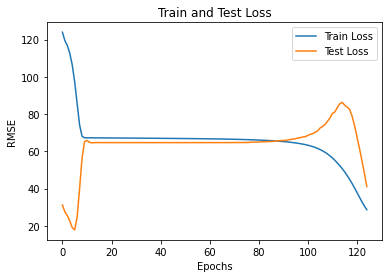

In [21]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel_Dense(input_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x[data.train_mask].to(device), train_adj).flatten()
    loss = criterion(out.squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), adj_matrix).flatten()
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))

            out_train = model(data.x[data.train_mask].to(device), train_adj).flatten()
            train_rmse = torch.sqrt(torch.mean((out_train.squeeze() - data.y[data.train_mask].squeeze())**2))

            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

plt.plot(range(len(train_rmse_list)), train_rmse_list, label='Train Loss')
plt.plot(range(len(test_rmse_list)), test_rmse_list, label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [22]:
model.eval()
with torch.no_grad():
        out = model(data.x.to(device), adj_matrix)  # Predicted PM values
        out = out.flatten()
        test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))

        out_train = model(data.x[data.train_mask].to(device), train_adj).flatten()
        train_rmse = torch.sqrt(torch.mean((out_train.squeeze() - data.y[data.train_mask].squeeze())**2))
        
print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Train RMSE:  tensor(26.9374)
Test RMSE:  tensor(36.2862)


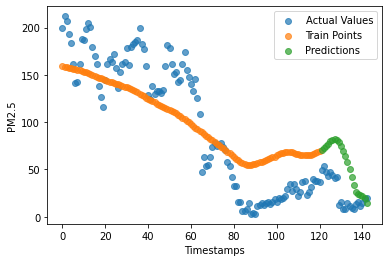

In [23]:
n_train = len(train_adj)
plt.scatter(range(len(data.y)), data.y, label = 'Actual Values', alpha = 0.7)
plt.scatter(range(n_train), out[data.train_mask].squeeze(), label = 'Train Points', alpha = 0.7)
plt.scatter(range(n_train, len(data.y)), out[data.test_mask].squeeze(), label = 'Predictions', alpha = 0.7)
plt.ylabel('PM2.5')
plt.xlabel('Timestamps')
plt.legend();

# GCNConv

In [11]:
def time_graph(df):
    G = nx.DiGraph()
    for i in range(len(df)):
        time = df.iloc[i]['time']
        pm = df.iloc[i]['PM25_Concentration']
        weather = df.iloc[i]['weather']
        temperature = df.iloc[i]['temperature']
        humidity = df.iloc[i]['humidity']
        
        G.add_node(i, time = time, pm=pm, weather = weather, temperature = temperature, humidity = humidity)
        
        for j in range(i + 1, len(df)):
            time2 = df.iloc[j]['time']
            G.add_edge(i, j, weight = 1/(time2-time)**0.5)
    
    return G

In [12]:
def create_dataset(G):
    node_features = [(G.nodes[node]['weather'], G.nodes[node]['temperature'], G.nodes[node]['humidity']) for node in G.nodes]
    
    edge_weights = []
#     undirected_edges = []
    for edge in G.edges:
#         undirected_edges.append(edge)
#         undirected_edges.append((edge[1], edge[0]))  # Add the reverse edge
        edge_weights.append(G.get_edge_data(edge[0], edge[1]))
#         edge_weights.append(G.get_edge_data(edge[1], edge[0]))
        
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    y = torch.tensor([G.nodes[node]['pm'] for node in G.nodes], dtype=torch.float).view(-1, 1)
    train_mask = torch.zeros(y.size(0), dtype=torch.bool)
    test_mask = torch.zeros(y.size(0), dtype=torch.bool)
    
#     test_mask[50:80] = True
#     train_mask = [False if i else True for i in test_mask]
    
    n_train = int(0.85*len(G.nodes))
    train_mask[:n_train] = True
    test_mask[n_train:] = True
    
    data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weight = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask)
    return data, n_train

In [13]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 8)
        self.linear1 = nn.Linear(8, 8)
        self.linear2 = nn.Linear(8, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [14]:
G = time_graph(df)
data, n_train = create_dataset(G)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:18<00:00, 133.69it/s]


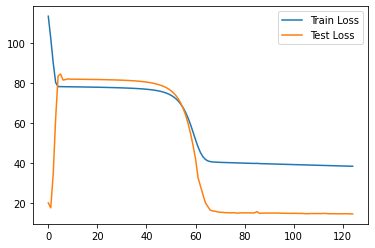

In [15]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionModel(input_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_rmse_list = []
test_rmse_list = []

for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.train_mask].squeeze(), data.y[data.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%20==0):
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
            train_rmse_list.append(train_rmse.item())
            test_rmse_list.append(test_rmse.item())
        model.train()

plt.plot(range(len(train_rmse_list)), train_rmse_list, label='Train Loss')
plt.plot(range(len(test_rmse_list)), test_rmse_list, label='Test Loss')

plt.legend()
plt.show()

In [16]:
model.eval()
with torch.no_grad():
    out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data.train_mask].squeeze() - data.y[data.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
    print(train_rmse)
    print(test_rmse)

tensor(38.3250)
tensor(14.5298)


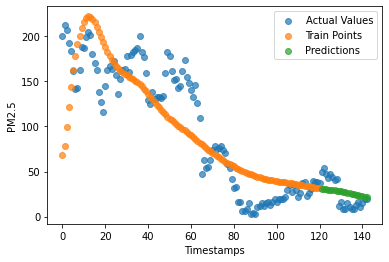

In [17]:
plt.scatter(range(len(data.y)), data.y, label = 'Actual Values', alpha = 0.7)
plt.scatter(range(n_train), out[data.train_mask].squeeze(), label = 'Train Points', alpha = 0.7)
plt.scatter(range(n_train, len(data.y)), out[data.test_mask].squeeze(), label = 'Predictions', alpha = 0.7)
plt.ylabel('PM2.5')
plt.xlabel('Timestamps')
plt.legend();